In [8]:
%matplotlib widget

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm.autonotebook import trange, tqdm
import torch
import matplotlib.patches as patches
from torch.profiler import profile, record_function, ProfilerActivity
from typing import Optional, List
import math

In [9]:
# Helper function to determine extent of domain either based on given values or based on the input positions
@torch.jit.script
def getDomainExtents(positions, minDomain : Optional[torch.Tensor], maxDomain : Optional[torch.Tensor]):
    if minDomain is not None and isinstance(minDomain, list):
        minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    elif minDomain is not None:
        minD = minDomain
    else:
        minD = torch.min(positions, dim = 0)[0]
    if maxDomain is not None and isinstance(minDomain, list):
        maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    elif maxDomain is not None:
        maxD = maxDomain
    else:
        maxD = torch.max(positions, dim = 0)[0]
    return minD, maxD

In [10]:
# Convert particle volume to support in 1 2 or 3 dimensions
@torch.jit.script
def volumeToSupport(volume : float, targetNeighbors : int, dim : int):
    if dim == 1:
        # N_h = 2 h / v -> h = N_h * v / 2
        return targetNeighbors * volume / 2
    elif dim == 2:
        # N_h = \pi h^2 / v -> h = \sqrt{N_h * v / \pi}
        return torch.sqrt(targetNeighbors * volume / np.pi)
    else:
        # N_h = 4/3 \pi h^3 / v -> h = \sqrt[3]{N_h * v / \pi * 3/4}
        return torch.pow(targetNeighbors * volume / np.pi * 3 /4, 1/3)
# Given a domain size [qMin, qMax] and a support size h,  find the next larger support radius that evenly divides the domain
@torch.jit.script
def compute_h(qMin, qMax, referenceSupport : float):
    qExtent = qMax - qMin
    # print('qExtent:', qExtent)

    numCells = torch.floor(qExtent / referenceSupport)
    # print('numCells:', numCells, '(%g : %g)' % (qExtent[0] / referenceSupport, qExtent[1] / referenceSupport))
    h = qExtent / numCells
    # print('new h:', h)  
    return torch.max(h)
    return torch.max(torch.ceil(h / referenceSupport) * referenceSupport)

In [20]:
# sort particle positions
@torch.jit.script
def sortReferenceParticles(referenceParticles, referenceSupport : float, domainMin, domainMax):
    with record_function("sort"): 
        qMin = domainMin# - referenceSupport / 2
        qMax = domainMax# + referenceSupport / 2
        with record_function("sort - index Calculation"): 
            hCell = compute_h(qMin, qMax, referenceSupport)


            qExtent = qMax - qMin
            cellCount = torch.ceil(qExtent / (hCell)).to(torch.int32)
            indices = torch.floor((referenceParticles - qMin) / hCell).to(torch.int32)
            linearIndices = indices[:,0] + cellCount[0] * indices[:,1]
        with record_function("sort - actual argsort"): 
            sortingIndices = torch.argsort(linearIndices)
        with record_function("sort - sorting data"): 
            sortedLinearIndices = linearIndices[sortingIndices]
            # sortedPositions = referenceParticles[sortingIndices,:]
            # sortedSupport = referenceSupport[sortingIndices]
    return sortedLinearIndices, sortingIndices, \
            cellCount, qMin, qMax, float(hCell)

# Hash function with prime numbers
# We use the prime numbers to avoid collisions as best as possible
# The numbers are arbitrary and could be changed but are used as is in literature
@torch.jit.script
def hashCellIndices(cellIndices, hashMapLength : int):
    primes = [73856093, 19349663, 83492791]
    if cellIndices.dim() == 1:
        return cellIndices % hashMapLength
    elif cellIndices.dim() == 2:
        return (cellIndices[:,0] * primes[0] + cellIndices[:,1] * primes[1]) % hashMapLength
    elif cellIndices.dim() == 3:
        return (cellIndices[:,0] * primes[0] + cellIndices[:,1] * primes[1] + cellIndices[:,2] * primes[2]) % hashMapLength
    else: 
        raise ValueError('Only 1D, 2D and 3D supported')
    
# Compute the support of the grid based on the support of the particles
@torch.jit.script
def computeGridSupport(queryParticleSupports : Optional[torch.Tensor], referenceSupports : Optional[torch.Tensor], mode : str = 'symmetric'):  
    device = queryParticleSupports.device if queryParticleSupports is not None else (referenceSupports.device if referenceSupports is not None else torch.device('cpu'))
    dtype = queryParticleSupports.dtype if queryParticleSupports is not None else (referenceSupports.dtype if referenceSupports is not None else torch.float32)
    hMax = torch.tensor(0.0, device = device, dtype = dtype)
    if mode == 'scatter':
        assert referenceSupports is not None, 'referenceSupports must be provided for scatter mode'
        hMax = torch.max(referenceSupports) if referenceSupports is not None else 0.0
    elif mode == 'gather':
        assert queryParticleSupports is not None, 'queryParticleSupports must be provided for gather mode'
        hMax = torch.max(queryParticleSupports) if queryParticleSupports is not None else 0.0
    elif mode == 'symmetric':
        assert referenceSupports is not None, 'referenceSupports must be provided for symmetric mode'
        assert queryParticleSupports is not None, 'queryParticleSupports must be provided for symmetric mode'
        referenceHMax = torch.max(referenceSupports) if referenceSupports is not None else 0.0
        queryHMax = torch.max(queryParticleSupports) if queryParticleSupports is not None else 0.0
        hMax = torch.max(referenceHMax, queryHMax)
    else:
        raise ValueError('mode must be one of scatter, gather or symmetric')
    return hMax

# Count the unique entries in inidices and pad to the shape of positions.shape[0]
@torch.jit.script
def countUniqueEntries(indices, positions):
    ii, nit = torch.unique(indices, return_counts=True)
    ni = torch.zeros(positions.shape[0], dtype = nit.dtype, device = positions.device)
    ni[ii] = nit
    return ii, ni

In [21]:
@torch.jit.script
def buildCompactHashMap(x, minDomain, maxDomain, periodicity : List[bool], hMax : float, hashMapLength : int):# Compute domain extents
    minD, maxD = getDomainExtents(x, minDomain, maxDomain)
    # Sort the particles (and supports) based on a linear index
    # Returns only a key
    sortedLinear, sortIndex, numCells, qMin, qMax, hCell = sortReferenceParticles(x, hMax, minD, maxD)
    # Do the actual resort
    sortedPositions = x[sortIndex,:]
    # sortedSupports = xSupport[sortIndex]
    
    # compact teh list of occupied cells
    cellIndices, cellCounters = torch.unique_consecutive(sortedLinear, return_counts=True, return_inverse=False)
    cellCounters = cellCounters.to(torch.int32)
    # Needs to zero padded for the indexing to work properly as the 0th cell is valid and cumsum doesn't include the first element

    cumCell = torch.hstack((torch.tensor([0], device = cellIndices.device, dtype=cellCounters.dtype),torch.cumsum(cellCounters,dim=0)))[:-1]#.to(torch.int32)

    # We can now use the cumCell to index into the sortedIndices to get the cell index for each particle
    # We could have reversed the linear indices to get the cell index for each cell, but this is more reliable and avoids inverse computations
    sortedIndices = torch.floor((sortedPositions - qMin) / hCell).to(torch.int32)
    cellGridIndices = sortedIndices[cumCell,:]
    # Cell indices contains the linear indices of the particles in each cell
    # cellCounters contains the number of particles in each cell
    # cumCell contains the cumulative sum of the number of particles in each cell, i.e., the offset into the cell
    # With this information we can build a datastructure with [begin, end) for each cell using cellCounters and cumCell!
    cellTable = torch.stack((cellIndices, cumCell, cellCounters), dim = 1)

    # Hash the cell indices and sort them to get a compact list of occupied cells with unique_consecutive, same as for the cells
    hashedIndices = hashCellIndices(cellGridIndices, hashMapLength)
    hashIndexSorting = torch.argsort(hashedIndices)
    hashMap, hashMapCounters = torch.unique_consecutive(hashedIndices[hashIndexSorting], return_counts=True, return_inverse=False)
    hashMapCounters = hashMapCounters.to(torch.int32)
    # Resort the entries based on the hashIndexSorting so they can be accessed through the hashmap
    sortedCellIndices = cellIndices[hashIndexSorting]
    sortedCellTable = torch.stack([c[hashIndexSorting] for c in cellTable.unbind(1)], dim = 1)
    # print(sortedCellTable)
    # sortedCumCell = cellCounters[hashIndexSorting]
    # cellSpan = cellTable[hashIndexSorting,0][hashIndexSorting]

    # Same construction as for the cell list but this time we create a more direct table
    # The table contains the start and length for each cell in the hash table and -1 if the cell is empty
    hashTable = hashMap.new_ones(hashMapLength,2) * -1
    hashTable[:,1] = 0
    hashMap64 = hashMap.to(torch.int64)
    hashTable[hashMap64,0] = torch.hstack((torch.tensor([0], device = sortedCellIndices.device, dtype=sortedCellIndices.dtype),torch.cumsum(hashMapCounters,dim=0)))[:-1].to(torch.int32) #torch.cumsum(hashMapCounters, dim = 0) #torch.arange(hashMap.shape[0], device=hashMap.device)

    hashTable[hashMap64,1] = hashMapCounters

    return sortedPositions, hashTable, sortedCellTable, hCell, qMin,qMax, numCells, sortIndex


In [22]:
from typing import Tuple, List

@torch.jit.script
def queryCell(cellIndex, hashTable, hashMapLength : int, numCells, cellTable):
    # print('cellIndex:', cellIndex)
    linearIndex = cellIndex[0] + numCells[0] * cellIndex[1]
    # print('linearIndex:', linearIndex)
    hashedIndex = hashCellIndices(cellIndex.view(-1,cellIndex.shape[0]), hashMapLength)
    # print('hashedIndex:', hashedIndex)

    tableEntry = hashTable[hashedIndex,:]
    # print(tableEntry)
    hBegin = tableEntry[:,0][0]
    hLength = tableEntry[:,1][0]
    # print('hBegin:', hBegin, 'hLength:', hLength)

    if hBegin != -1:
        cell = cellTable[hBegin:hBegin + hLength]
        # cellEntries = cellSpan[hBegin:hBegin + hLength]
        # cellLengths = sortedCumCell[hBegin:hBegin + hLength]
        # cellLinearIndices = sortedCellIndices[hBegin:hBegin + hLength]
        # print('cellEntries:', cell[:,1])
        # print('cellLengths:', cell[:,2])
        # print('cellLinearIndices:', cell[:,0])
        if torch.isin(cell[:,0], linearIndex):
            # print('found')
            # print('cell', cell)
            cBegin = cell[cell[:,0] == linearIndex, 1][0]
            cLength = cell[cell[:,0] == linearIndex, 2][0]
            particlesInCell = torch.arange(cBegin, cBegin + cLength, device = linearIndex.device, dtype = linearIndex.dtype)
            # print(particlesInCell)
            return particlesInCell

    return torch.empty(0, dtype = linearIndex.dtype, device = linearIndex.device)



@torch.jit.script
def findNeighbors(queryPosition, querySupport: Optional[torch.Tensor], 
            searchRange : int, sortedPositions, sortedSupport: Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, 
            cellTable, qMin, hCell : float, maxDomain, minDomain, periodicity, mode : str):
    centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
    neighborhood = []
    for xx in range(-searchRange,searchRange + 1):
        for yy in range(-searchRange,searchRange + 1):
            cellIndex = centerCell + torch.tensor([xx,yy], device = centerCell.device, dtype = centerCell.dtype)
            cellIndex = cellIndex % numCells
            particlesInCell = queryCell(cellIndex, hashTable, hashMapLength, numCells, cellTable)
            # print('offset:', xx, yy, 'cellIndex:', cellIndex, 'particlesInCell:', particlesInCell)

            if particlesInCell.numel() > 0:
                referencePositions = sortedPositions[particlesInCell,:]
                # referenceSupports = sortedSupport[particlesInCell]

                
                if torch.any(periodicity):
                    distances = []
                    for i in range(queryPosition.shape[0]):
                        if periodicity[i]:
                            domainLength = (maxDomain[i] - minDomain[i])
                            distances.append((referencePositions[:,i] - queryPosition[i] + domainLength/2) % domainLength - domainLength/2)
                            # print('.')
                        else:
                            distances.append(referencePositions[:,i] - queryPosition[i])
                    relPositions = torch.stack(distances, dim = 1)
                    # print(relPositions)
                else:
                    relPositions = referencePositions - queryPosition
                # print(relPositions)
                # print(particlesInCell)
                    # domainLength = (maxDomain - minDomain)
                # relPosition = (relPosition + domainLength/2) % domainLength - domainLength/2
                distances = torch.norm(relPositions, dim=1, p=2)
                if mode == 'scatter' and sortedSupport is not None:
                    hij = sortedSupport[particlesInCell]
                    neighbors = particlesInCell[distances < hij]
                    neighborhood.append(neighbors)
                    # neighborhood[counter:counter + neighbors.numel()] = neighbors
                    # counter += neighbors.numel()
                elif mode == 'gather' and querySupport is not None:
                    hij = querySupport
                    neighbors = particlesInCell[distances < hij]
                    neighborhood.append(neighbors)
                    # neighborhood[counter:counter + neighbors.numel()] = neighbors
                    # counter += neighbors.numel()
                elif mode == 'symmetric' and querySupport is not None and sortedSupport is not None:
                    hij = (sortedSupport[particlesInCell] + querySupport) / 2
                    neighbors = particlesInCell[distances < hij]
                    neighborhood.append(neighbors)
                    # neighborhood[counter:counter + neighbors.numel()] = neighbors
                    # counter += neighbors.numel()
                # print('offset:', xx, yy, distances)
                # neighbors = particlesInCell[distances < querySupport]
                # neighborhood.append(neighbors)
    if len(neighborhood) > 0:
        return torch.hstack(neighborhood)
    return torch.empty(0, dtype = centerCell.dtype, device = centerCell.device)


@torch.jit.script
def findNeighborsFixed(queryPosition, querySupport : Optional[torch.Tensor], 
            searchRange : int, sortedPositions, sortedSupport : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, 
            cellTable, qMin, hCell : float, maxDomain, minDomain, periodicity, bufferSize: int, mode : str):
    centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
    neighborhood = torch.zeros(bufferSize, dtype = centerCell.dtype, device = centerCell.device)
    counter = 0
    for xx in range(-searchRange,searchRange + 1):
        for yy in range(-searchRange,searchRange + 1):
            cellIndex = centerCell + torch.tensor([xx,yy], device = centerCell.device, dtype = centerCell.dtype)
            cellIndex = cellIndex % numCells
            particlesInCell = queryCell(cellIndex, hashTable, hashMapLength, numCells, cellTable)

            if particlesInCell.numel() > 0:
                referencePositions = sortedPositions[particlesInCell,:]
                # referenceSupports = sortedSupport[particlesInCell]

                
                if torch.any(periodicity):
                    distances = []
                    for i in range(queryPosition.shape[0]):
                        if periodicity[i]:
                            domainLength = (maxDomain[i] - minDomain[i])
                            distances.append((referencePositions[:,i] - queryPosition[i] + domainLength/2) % domainLength - domainLength/2)
                        else:
                            distances.append(referencePositions[:,i] - queryPosition[i])
                    relPositions = torch.stack(distances, dim = 1)
                else:
                    relPositions = referencePositions - queryPosition

                distances = torch.norm(relPositions, dim=1, p=2)
                if mode == 'scatter' and sortedSupport is not None:
                    hij = sortedSupport[particlesInCell]
                    neighbors = particlesInCell[distances < hij]
                    neighborhood[counter:counter + neighbors.numel()] = neighbors
                    counter += neighbors.numel()
                elif mode == 'gather' and querySupport is not None:
                    hij = querySupport
                    neighbors = particlesInCell[distances < hij]
                    neighborhood[counter:counter + neighbors.numel()] = neighbors
                    counter += neighbors.numel()
                elif mode == 'symmetric' and querySupport is not None and sortedSupport is not None:
                    hij = (sortedSupport[particlesInCell] + querySupport) / 2
                    neighbors = particlesInCell[distances < hij]
                    neighborhood[counter:counter + neighbors.numel()] = neighbors
                    counter += neighbors.numel()

    return neighborhood[:counter]


@torch.jit.script
def countNeighbors(queryPosition, querySupport : Optional[torch.Tensor], 
            searchRange : int, sortedPositions, sortedSupport : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, 
            cellTable, qMin, hCell : float, maxDomain, minDomain, periodicity, mode : str):
    centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
    counter = torch.tensor(0, dtype = centerCell.dtype, device = centerCell.device)
    for xx in range(-searchRange,searchRange + 1):
        for yy in range(-searchRange,searchRange + 1):
            cellIndex = centerCell + torch.tensor([xx,yy], device = centerCell.device, dtype = centerCell.dtype)
            cellIndex = cellIndex % numCells
            particlesInCell = queryCell(cellIndex, hashTable, hashMapLength, numCells, cellTable)
            # print('offset:', xx, yy, 'cellIndex:', cellIndex, 'particlesInCell:', particlesInCell)

            if particlesInCell.numel() > 0:
                referencePositions = sortedPositions[particlesInCell,:]
                # referenceSupports = sortedSupport[particlesInCell]

                
                if torch.any(periodicity):
                    distances = []
                    for i in range(queryPosition.shape[0]):
                        if periodicity[i]:
                            domainLength = (maxDomain[i] - minDomain[i])
                            distances.append((referencePositions[:,i] - queryPosition[i] + domainLength/2) % domainLength - domainLength/2)
                            # print('.')
                        else:
                            distances.append(referencePositions[:,i] - queryPosition[i])
                    relPositions = torch.stack(distances, dim = 1)
                    # print(relPositions)
                else:
                    relPositions = referencePositions - queryPosition
                # print(relPositions)
                # print(particlesInCell)
                    # domainLength = (maxDomain - minDomain)
                # relPosition = (relPosition + domainLength/2) % domainLength - domainLength/2
                distances = torch.norm(relPositions, dim=1, p=2)
                # print('offset:', xx, yy, distances)
                if mode == 'scatter' and sortedSupport is not None:
                    hij = sortedSupport[particlesInCell]
                    counter += torch.sum(distances < hij)
                elif mode == 'gather' and querySupport is not None:
                    hij = querySupport
                    counter += torch.sum(distances < hij)
                elif mode == 'symmetric' and querySupport is not None and sortedSupport is not None:
                    hij = (sortedSupport[particlesInCell] + querySupport) / 2
                    counter += torch.sum(distances < hij)
                # neighbors = particlesInCell[distances < querySupport]
                # neighborhood.append(neighbors)
    return counter

In [23]:
@torch.jit.script
def buildNeighborOffsetList(queryPositions, queryParticleSupports : Optional[torch.Tensor], sortedPositions, sortedSupports : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, sortedCellTable, qMin, hCell : float, maxD, minD, periodicity : List[bool], mode : str):
    neighborCounter = torch.zeros(queryPositions.shape[0], dtype = torch.int32)
    for index in range(queryPositions.shape[0]):
        neighborCounter[index] = countNeighbors(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), mode)

    neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = queryPositions.device), torch.cumsum(neighborCounter, dim = 0)))[:-1]
    neighborListLength = neighborOffsets[-1] + neighborCounter[-1]

    return neighborCounter, neighborOffsets, neighborListLength

@torch.jit.script
def buildNeighborListFixed(neighborListLength, sortIndex, queryPositions, queryParticleSupports : Optional[torch.Tensor], sortedPositions, sortedSupports : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, sortedCellTable, qMin, hCell : float, maxD, minD, periodicity: List[bool], neighborCounter, neighborOffsets, mode : str):
    i = torch.zeros(neighborListLength, dtype = sortIndex.dtype, device = queryPositions.device)
    j = torch.zeros(neighborListLength, dtype = sortIndex.dtype, device = queryPositions.device)
    for index in range(queryPositions.shape[0]):
        neighborhood = findNeighborsFixed(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), bufferSize = neighborCounter[index], mode =  mode)
        
        i[neighborOffsets[index]:neighborOffsets[index] + neighborCounter[index]] = index
        j[neighborOffsets[index]:neighborOffsets[index] + neighborCounter[index]] = sortIndex[neighborhood]

    return i, j

@torch.jit.script
def buildNeighborListDynamic(sortIndex, queryPositions, queryParticleSupports : Optional[torch.Tensor], sortedPositions, sortedSupports : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, sortedCellTable, qMin, hCell : float, maxD, minD, periodicity: List[bool],mode : str):
    # dynamic size approach
    i = []
    j = []

    for index in range(queryPositions.shape[0]):
        neighborhood = findNeighbors(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), mode)
        i.append(torch.ones(neighborhood.shape[0], dtype = torch.int32) * index)
        j.append(neighborhood)

    i = torch.hstack(i)
    j = sortIndex[torch.hstack(j)]

    return i, j


In [24]:
@torch.jit.script
def neighborSearch(
    queryPositions, queryParticleSupports : Optional[torch.Tensor], 
    referencePositions, referenceSupports : Optional[torch.Tensor], 
    minDomain : Optional[torch.Tensor], maxDomain : Optional[torch.Tensor], periodicity : List[bool], hashMapLength : int, mode : str = 'symmetric'):
    hMax = computeGridSupport(queryParticleSupports, referenceSupports, mode)
    # Compute domain extents
    minD, maxD = getDomainExtents(referencePositions, minDomain, maxDomain)

    # Wrap x positions around periodic boundaries
    x = torch.vstack([component if not periodic else torch.remainder(component - minD[i], maxD[i] - minD[i]) + maxD[i] for i, (component, periodic) in enumerate(zip(referencePositions.mT, periodicity))]).mT
    # Build hash table and cell table
    sortedPositions, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = buildCompactHashMap(x, minD, maxD, periodicity, hMax, hashMapLength)
    sortedSupports = referenceSupports[sortIndex] if referenceSupports is not None else None
    # Build neighbor list by first building a list of offsets and then the actual neighbor list
    neighborCounter, neighborOffsets, neighborListLength = buildNeighborOffsetList(queryPositions, queryParticleSupports, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, periodicity, mode)

    i,j = buildNeighborListFixed(neighborListLength, sortIndex, queryPositions, queryParticleSupports, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, periodicity, neighborCounter, neighborOffsets, mode)
    # compute number of neighbors per particle for convenience
    ii, ni = countUniqueEntries(i, queryPositions)
    jj, nj = countUniqueEntries(j, referencePositions)

    return (i,j), ni, nj, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex


In [25]:
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32)
# maxDomain = torch.tensor([ 2, 1], dtype = torch.float32)
periodicity = [False] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0]
dx = shortExtent / nx
h = volumeToSupport(dx**dim, 50, dim)

positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, nx))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim)
# enable for random positions for alternative debugging
# positions = torch.rand(nx**dim, dim) * 2 - 1

supports = torch.ones(positions.shape[0]) * h

print('positions:', positions.shape, positions.min(), positions.max())
print('supports:', supports.shape, supports.min(), supports.max())

ny = 16
# h = 0.1

# positions = torch.rand(n, 2) * 0.5 + 0.25
dy = dx.item()

xpos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1)
# y = torch.clone(x)
ySupport = torch.ones(y.shape[0]) * supports[0]

periodicity = [False] * dim

positions: torch.Size([1024, 2]) tensor(-0.9688) tensor(0.9688)
supports: torch.Size([1024]) tensor(0.2493) tensor(0.2493)


In [26]:

neighbors, ni, nj, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
    neighborSearch(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = 4096)



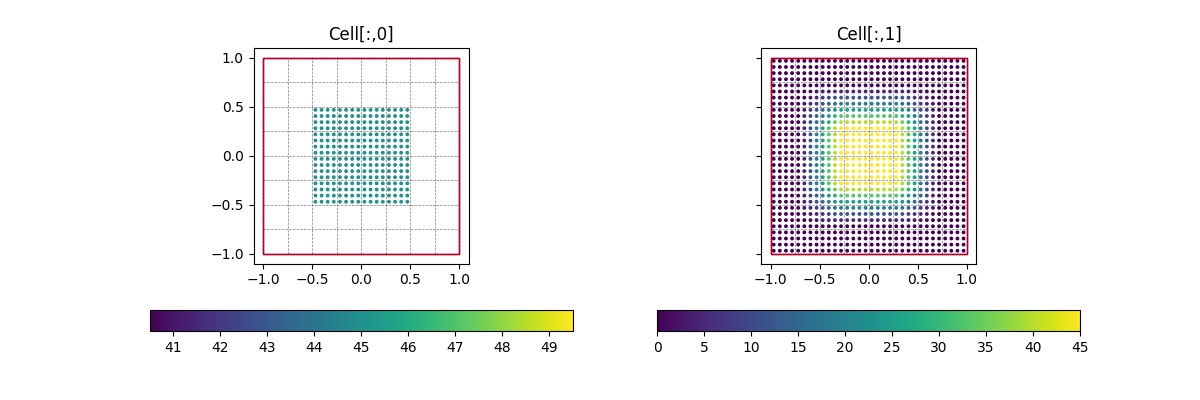

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 100 / math.sqrt(positions.shape[0])

sc = axis[0,0].scatter(y[:,0], y[:,1], c = ni, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Cell[:,0]')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = nj, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Cell[:,1]')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')

In [72]:
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32)
# maxDomain = torch.tensor([ 2, 1], dtype = torch.float32)
periodicity = [False] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0]
dx = shortExtent / nx
h = volumeToSupport(dx**dim, 50, dim)

positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, nx))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim)
# enable for random positions for alternative debugging
positions = torch.rand(nx**dim, dim) * 0.5 + 0.25

supports = torch.ones(positions.shape[0]) * h

print('positions:', positions.shape, positions.min(), positions.max())
print('supports:', supports.shape, supports.min(), supports.max())

positions: torch.Size([1024, 2]) tensor(0.2505) tensor(0.7497)
supports: torch.Size([1024]) tensor(0.2493) tensor(0.2493)


In [73]:
# Wrap x positions around periodic boundaries
x = torch.vstack([component if not periodic else torch.remainder(component - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, (component, periodic) in enumerate(zip(positions.mT, periodicity))]).mT
# Compute domain extents
minD, maxD = getDomainExtents(x, minDomain, maxDomain)

# Sort the particles (and supports) based on a linear index
# Returns only a key
sortedLinear, sortIndex, numCells, qMin, qMax, hCell = sortReferenceParticles(x, h, minD, maxD)
# Do the actual resort
sortedPositions = x[sortIndex,:]
sortedSupports = supports[sortIndex]

print('sortedPositions:', sortedPositions.shape, sortedPositions.min(), sortedPositions.max())
print('supports:', sortedSupports.shape, sortedSupports.min(), sortedSupports.max())

print(hCell)

sortedPositions: torch.Size([1024, 2]) tensor(0.2505) tensor(0.7497)
supports: torch.Size([1024]) tensor(0.2493) tensor(0.2493)
0.25


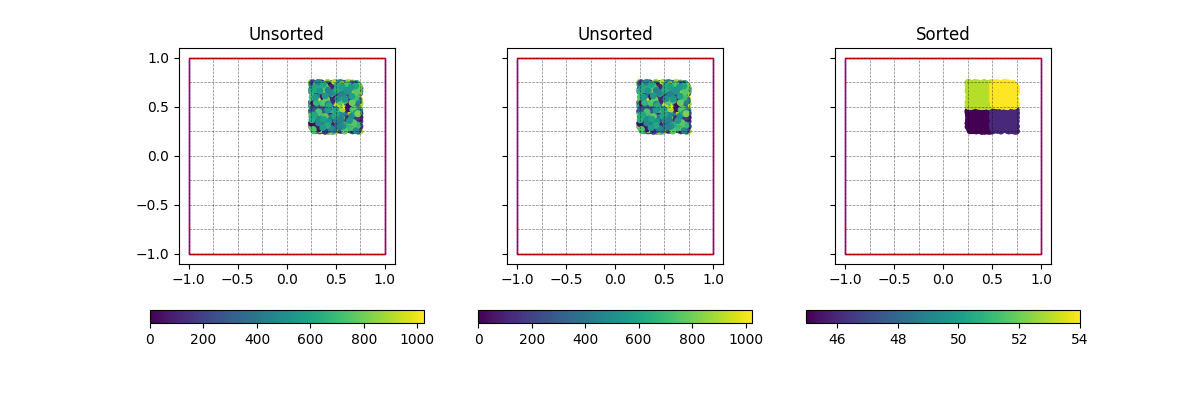

In [74]:
# Visualize the sorting to make sure it worked
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)

for i in range(numCells[0] + 1):
    for ii in range(3):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(3):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 500 / math.sqrt(x.shape[0])

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = sortIndex, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Unsorted')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(x[:,0], x[:,1], c = sortIndex, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Unsorted')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')

sc = axis[0,2].scatter(sortedPositions[:,0], sortedPositions[:,1], s = scatterSize, c = sortedLinear, label = 'Sorted')
fig.colorbar(sc, ax = axis[0,2], orientation='horizontal')
axis[0,2].set_title('Sorted')
axis[0,2].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,2].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,2].set_aspect(1, adjustable='box')



In [22]:
# compact teh list of occupied cells
cellIndices, cellCounters = torch.unique_consecutive(sortedLinear, return_counts=True, return_inverse=False)
cellCounters = cellCounters.to(torch.int32)
# Needs to zero padded for the indexing to work properly as the 0th cell is valid and cumsum doesn't include the first element

cumCell = torch.hstack((torch.tensor([0], device = cellIndices.device, dtype=cellCounters.dtype),torch.cumsum(cellCounters,dim=0)))[:-1]#.to(torch.int32)

# We can now use the cumCell to index into the sortedIndices to get the cell index for each particle
# We could have reversed the linear indices to get the cell index for each cell, but this is more reliable and avoids inverse computations
sortedIndices = torch.floor((sortedPositions - qMin) / hCell).to(torch.int32)
cellGridIndices = sortedIndices[cumCell,:]
# Cell indices contains the linear indices of the particles in each cell
# cellCounters contains the number of particles in each cell
# cumCell contains the cumulative sum of the number of particles in each cell, i.e., the offset into the cell
# With this information we can build a datastructure with [begin, end) for each cell using cellCounters and cumCell!
cellTable = torch.stack((cellIndices, cumCell, cellCounters), dim = 1)


print('cellIndices:', cellIndices.shape, 'cellCounters:', cellCounters.shape, 'cumCell:', cumCell.shape)
print('cellIndices:', cellIndices)
print('cellCounters:', cellCounters)
print('cellTable:', cellTable)
# print('cellGridIndices', cellGridIndices)

cellIndices: torch.Size([64]) cellCounters: torch.Size([64]) cumCell: torch.Size([64])
cellIndices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=torch.int32)
cellCounters: tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16], dtype=torch.int32)
cellTable: tensor([[   0,    0,   16],
        [   1,   16,   16],
        [   2,   32,   16],
        [   3,   48,   16],
        [   4,   64,   16],
        [   5,   80,   16],
        [   6,   96,   16],
        [   7,  112,   16],
        [   8,  128,   16],
       

In [23]:

# Arbitrary size, could be prime, could be other sizes. larger = less collisions but more memory pressure and consumption
hashMapLength = 4096

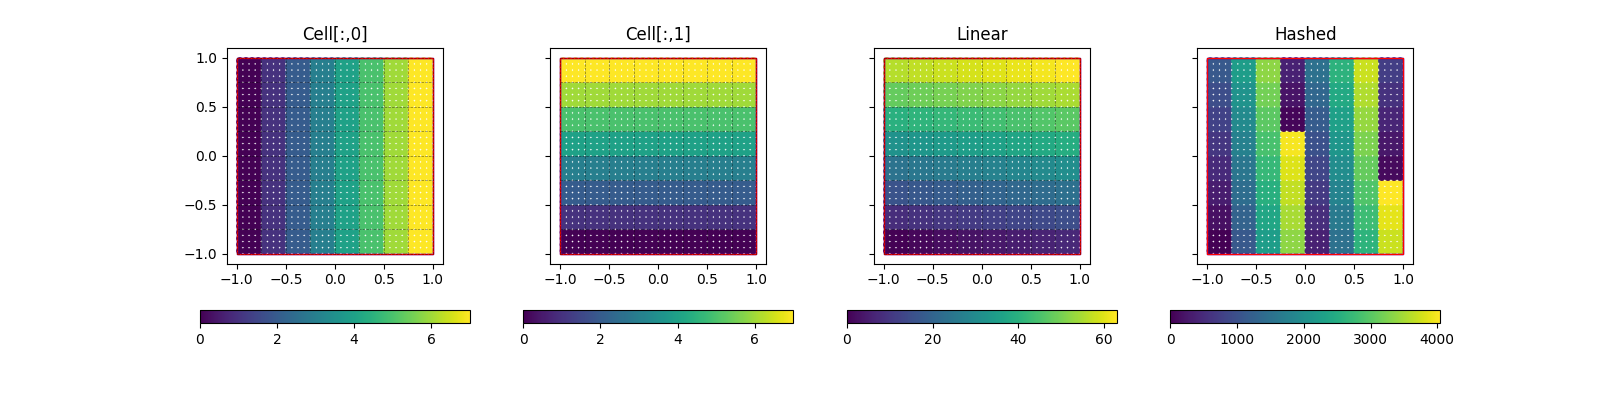

In [24]:
# Visualize the different particle indexing schemes
fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(3):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(3):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 600 / math.sqrt(x.shape[0])

sc = axis[0,0].scatter(sortedPositions[:,0], sortedPositions[:,1], c = sortedIndices[:,0], s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Cell[:,0]')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(sortedPositions[:,0], sortedPositions[:,1], c = sortedIndices[:,1], s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Cell[:,1]')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')


sc = axis[0,2].scatter(sortedPositions[:,0], sortedPositions[:,1], c = sortedLinear, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,2], orientation='horizontal')
axis[0,2].set_title('Linear')
axis[0,2].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,2].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,2].set_aspect(1, adjustable='box')

hashedParticleIndices = hashCellIndices(sortedIndices, hashMapLength)
sc = axis[0,3].scatter(sortedPositions[:,0], sortedPositions[:,1], c = hashedParticleIndices, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,3], orientation='horizontal')
axis[0,3].set_title('Hashed')
axis[0,3].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,3].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,3].set_aspect(1, adjustable='box')


In [25]:
# Hash the cell indices and sort them to get a compact list of occupied cells with unique_consecutive, same as for the cells
hashedIndices = hashCellIndices(cellGridIndices, hashMapLength)
hashIndexSorting = torch.argsort(hashedIndices)
hashMap, hashMapCounters = torch.unique_consecutive(hashedIndices[hashIndexSorting], return_counts=True, return_inverse=False)
hashMapCounters = hashMapCounters.to(torch.int32)
# Resort the entries based on the hashIndexSorting so they can be accessed through the hashmap
sortedCellIndices = cellIndices[hashIndexSorting]
sortedCellTable = torch.stack([c[hashIndexSorting] for c in cellTable.unbind(1)], dim = 1)
print(sortedCellTable)
# sortedCumCell = cellCounters[hashIndexSorting]
# cellSpan = cellTable[hashIndexSorting,0][hashIndexSorting]

# Same construction as for the cell list but this time we create a more direct table
# The table contains the start and length for each cell in the hash table and -1 if the cell is empty
hashTable = hashMap.new_ones(hashMapLength,2) * -1
hashTable[:,1] = 0
hashMap64 = hashMap.to(torch.int64)
hashTable[hashMap64,0] = torch.hstack((torch.tensor([0], device = sortedCellIndices.device, dtype=sortedCellIndices.dtype),torch.cumsum(hashMapCounters,dim=0)))[:-1].to(torch.int32) #torch.cumsum(hashMapCounters, dim = 0) #torch.arange(hashMap.shape[0], device=hashMap.device)

hashTable[hashMap64,1] = hashMapCounters

print(hashTable[hashTable[:,0] != -1].shape)

tensor([[   0,    0,   16],
        [  43,  688,   16],
        [  31,  496,   16],
        [   8,  128,   16],
        [  51,  816,   16],
        [  39,  624,   16],
        [  16,  256,   16],
        [  59,  944,   16],
        [   4,   64,   16],
        [  47,  752,   16],
        [  24,  384,   16],
        [  12,  192,   16],
        [  55,  880,   16],
        [  32,  512,   16],
        [  20,  320,   16],
        [  63, 1008,   16],
        [  40,  640,   16],
        [  28,  448,   16],
        [  48,  768,   16],
        [  36,  576,   16],
        [  56,  896,   16],
        [   1,   16,   16],
        [  44,  704,   16],
        [   9,  144,   16],
        [  52,  832,   16],
        [  17,  272,   16],
        [  60,  960,   16],
        [   5,   80,   16],
        [  25,  400,   16],
        [  13,  208,   16],
        [  33,  528,   16],
        [  21,  336,   16],
        [  41,  656,   16],
        [  29,  464,   16],
        [  49,  784,   16],
        [  37,  592,

In [27]:
# y = torch.clone(x)
# # y = y[0,:].view(1,-1)
# ySupport = supports
# periodicity = [True] * dim


# # queryPosition = torch.tensor([0.0, 0.0], dtype = x.dtype, device = x.device)
# queryPosition = x.min(dim = 0)[0]
# querySupport = ySupport[0]

# print(querySupport)
# print(queryPosition)

# centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)

# queryCell(centerCell, hashTable, hashMapLength, numCells, sortedCellTable)

# neighbors = findNeighbors(queryPosition, querySupport, 2, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity))

# print('neighbors',len(neighbors), neighbors)

In [29]:
ny = 16
# h = 0.1

# positions = torch.rand(n, 2) * 0.5 + 0.25
dy = dx.item()

xpos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1)
# y = torch.clone(x)
ySupport = torch.ones(y.shape[0]) * supports[0]

periodicity = [False] * dim

In [30]:
i = []
j = []

for index in tqdm(range(y.shape[0])):
    neighborhood = findNeighbors(y[index,:], ySupport[index], 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity))
    i.append(torch.ones(neighborhood.shape[0], dtype = torch.int32) * index)
    j.append(neighborhood)

i = torch.hstack(i)
j = sortIndex[torch.hstack(j)]

print(i.shape, j.shape)
print('i:', i.min(), i.max())
print('j:', j.min(), j.max())

ii, nit = torch.unique(i, return_counts=True)
ni = torch.zeros(y.shape[0], dtype = nit.dtype, device = x.device)
print('ni:', nit.shape, nit.min(), nit.max(), nit.sum(), nit)
ni[ii] = nit
# print(ii, ni)
jj, njt = torch.unique(j, return_counts=True)
nj = torch.zeros(x.shape[0], dtype = njt.dtype, device = y.device)
print('nj:', njt.shape, njt.min(), njt.max(), njt.sum(), njt)
nj[jj] = njt
# print(jj, nj)


  0%|          | 0/256 [00:00<?, ?it/s]

torch.Size([11520]) torch.Size([11520])
i: tensor(0, dtype=torch.int32) tensor(255, dtype=torch.int32)
j: tensor(166) tensor(857)
ni: torch.Size([256]) tensor(45) tensor(45) tensor(11520) tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 

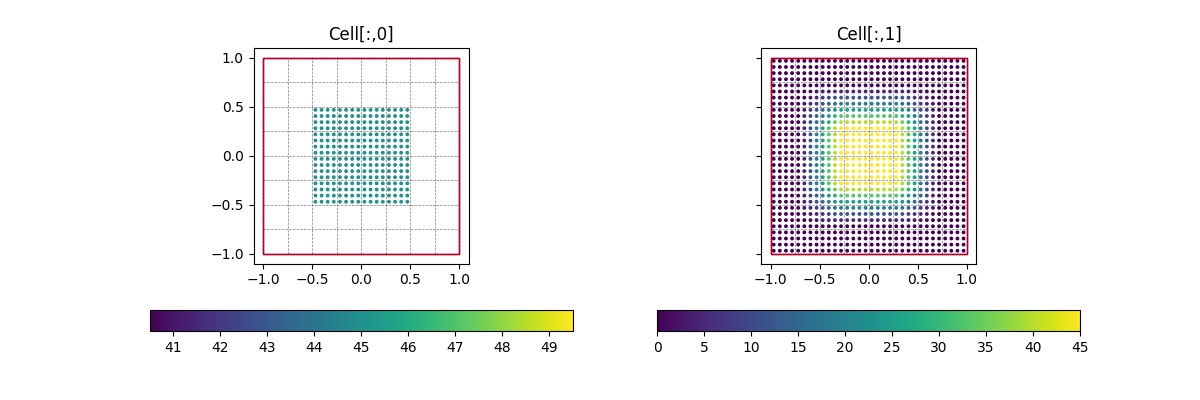

In [31]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 100 / math.sqrt(x.shape[0])

sc = axis[0,0].scatter(y[:,0], y[:,1], c = ni, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Cell[:,0]')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(x[:,0], x[:,1], c = nj, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Cell[:,1]')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')